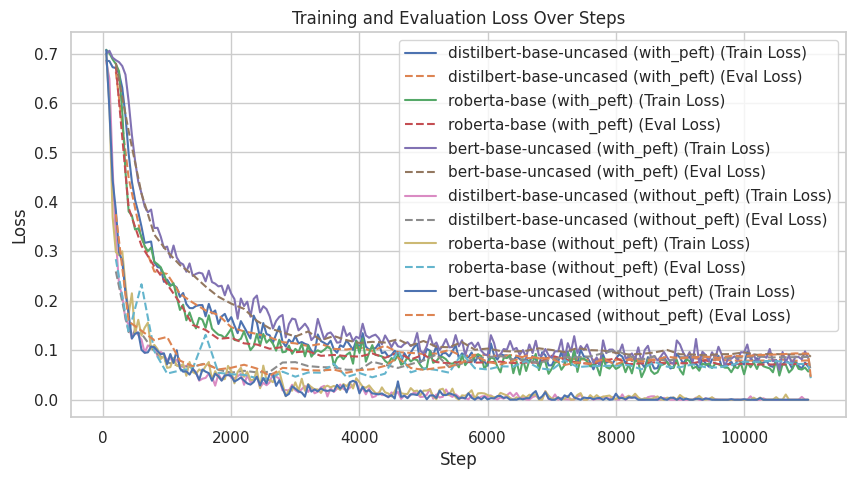

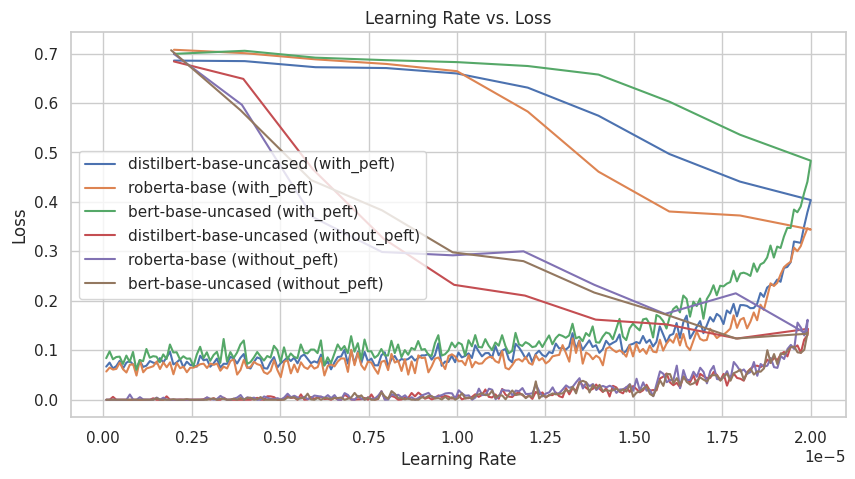

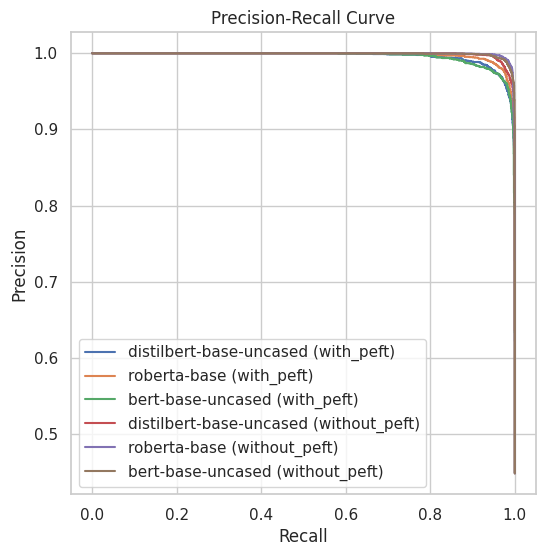

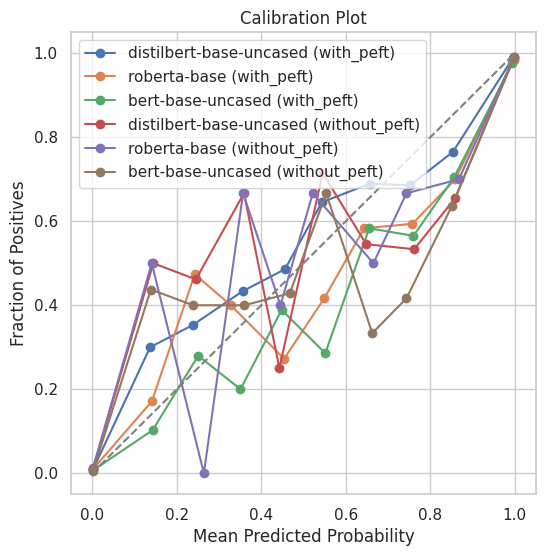

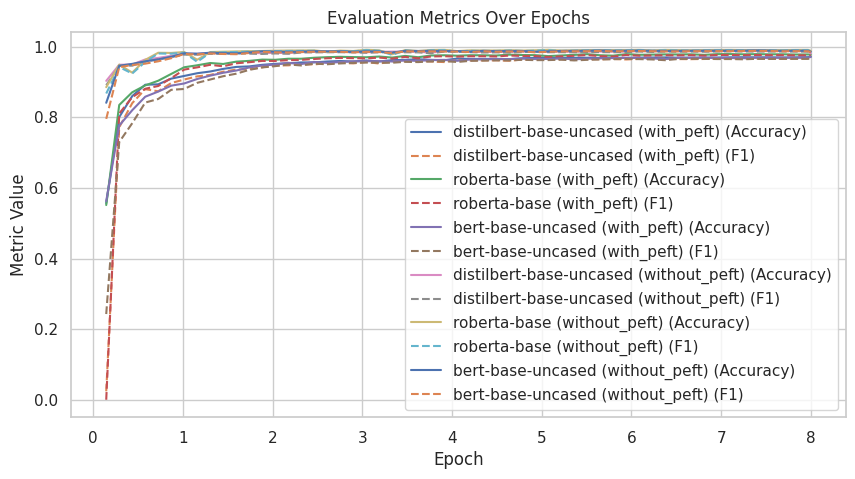

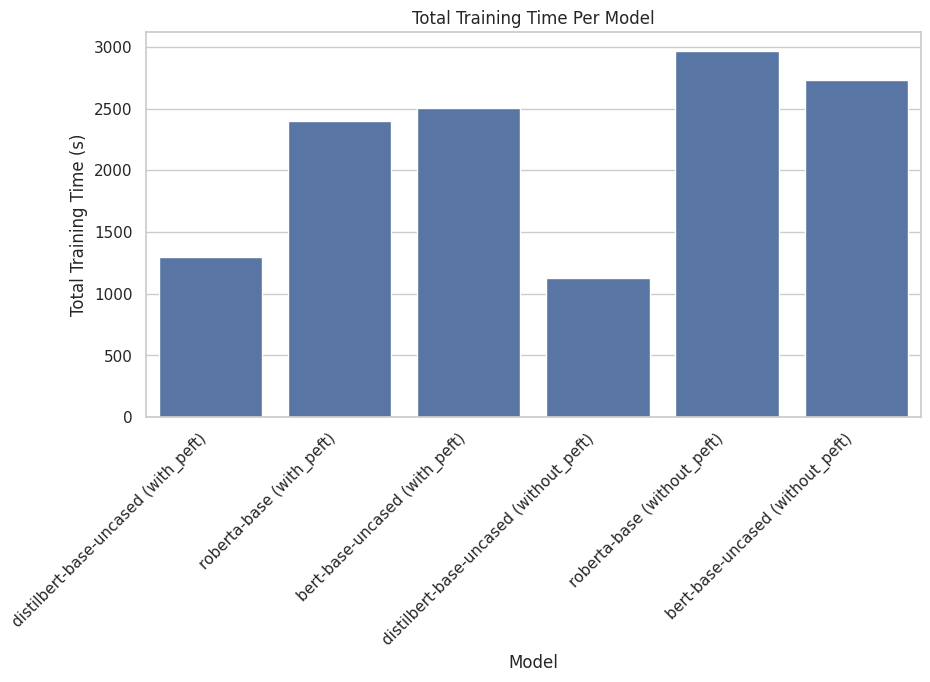

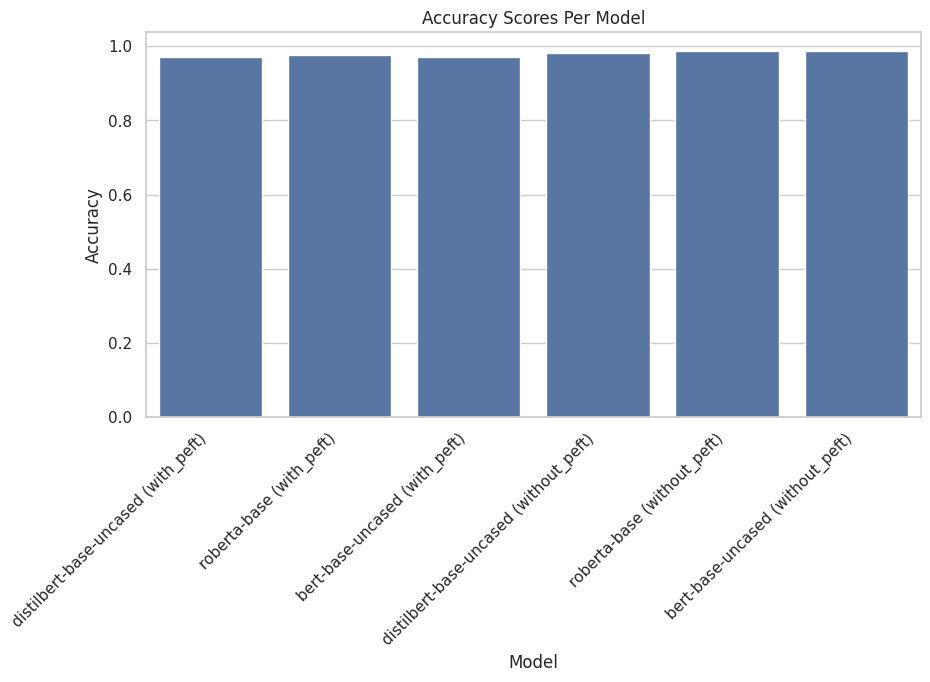

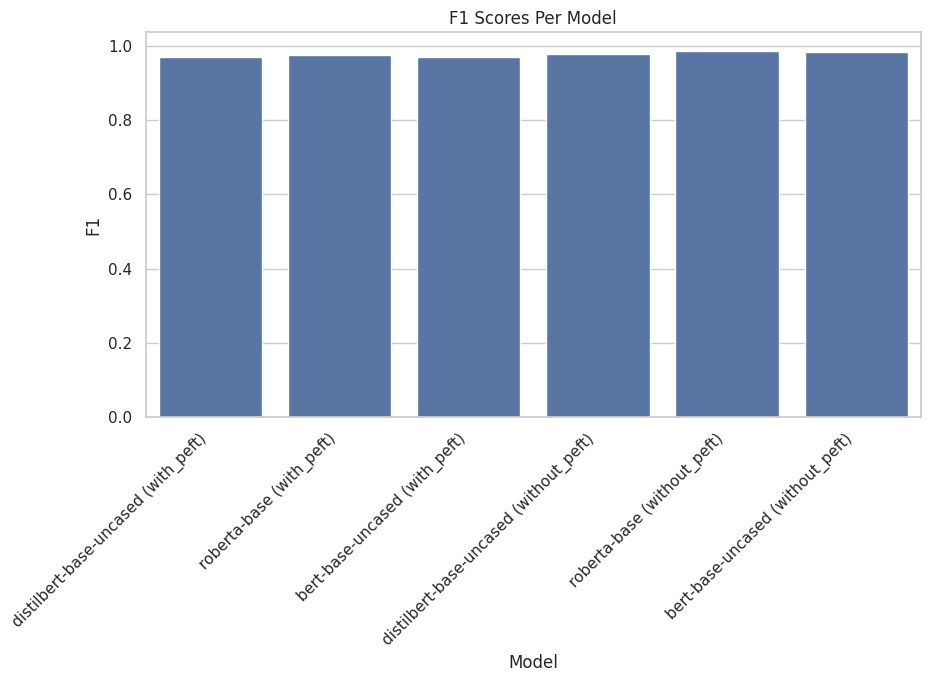

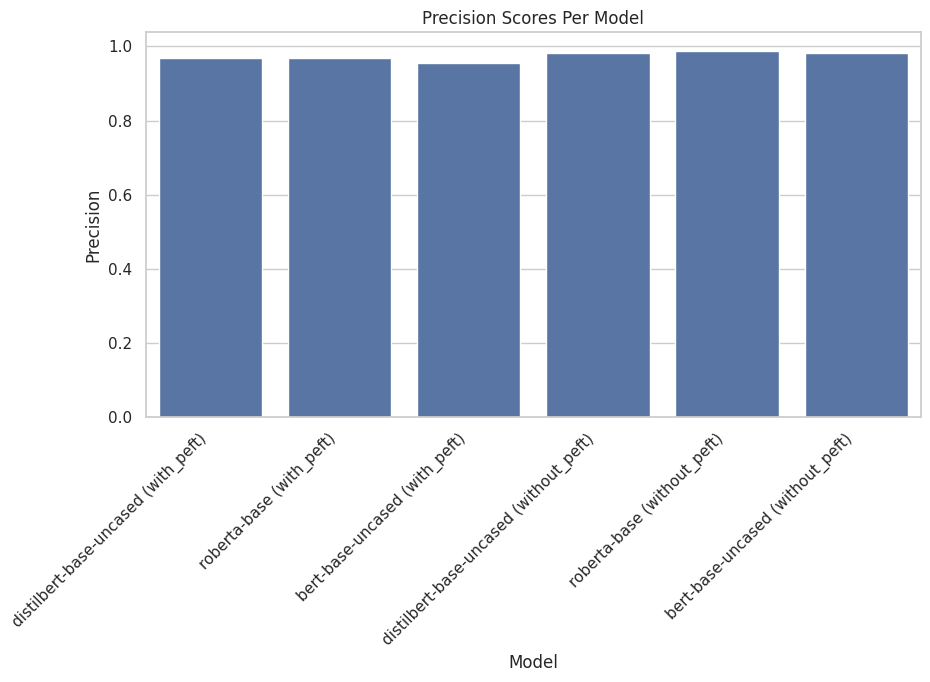

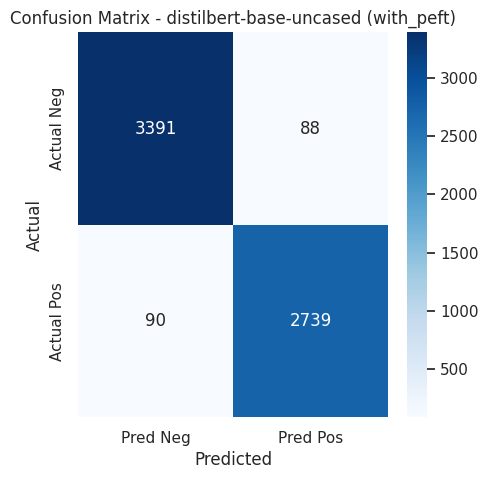

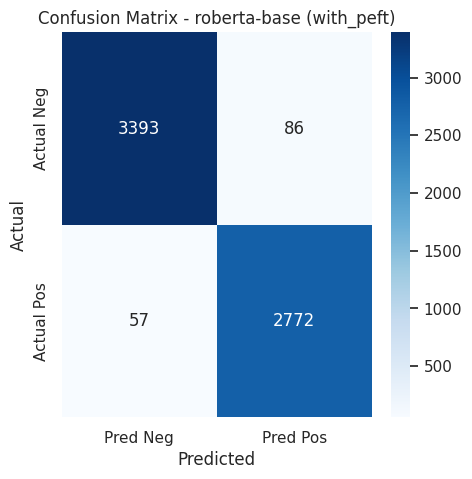

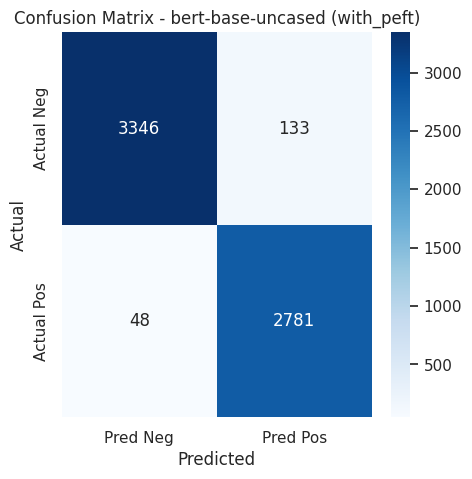

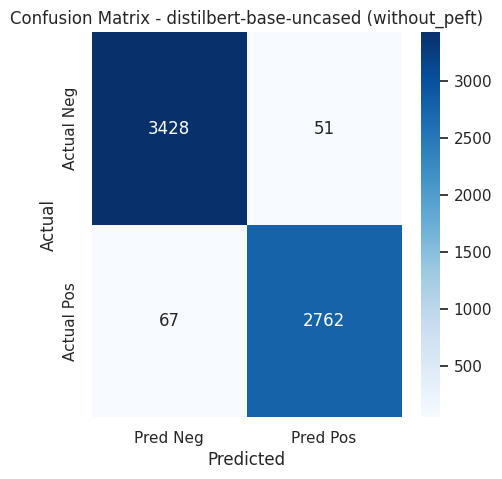

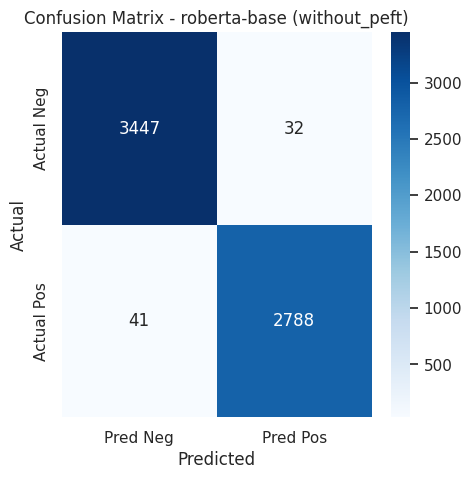

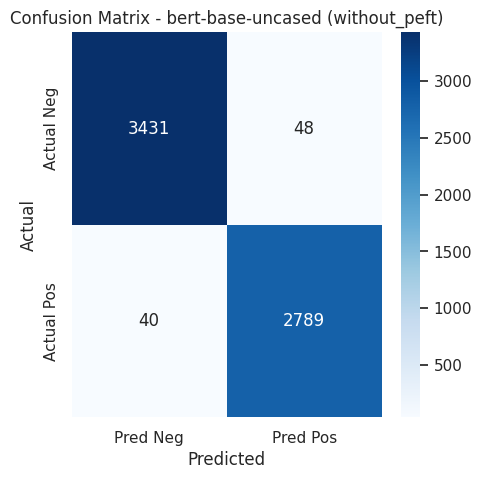

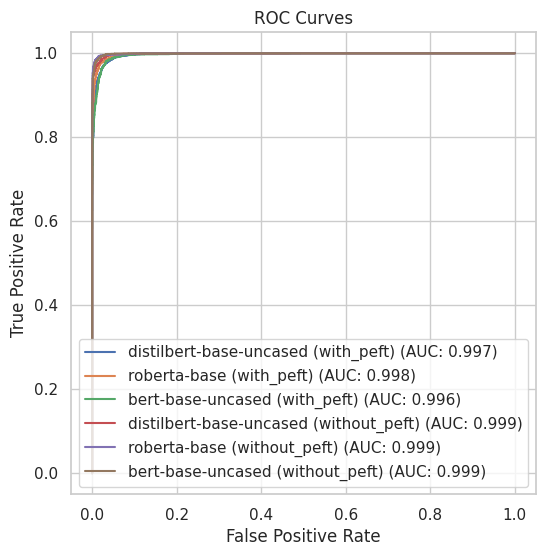

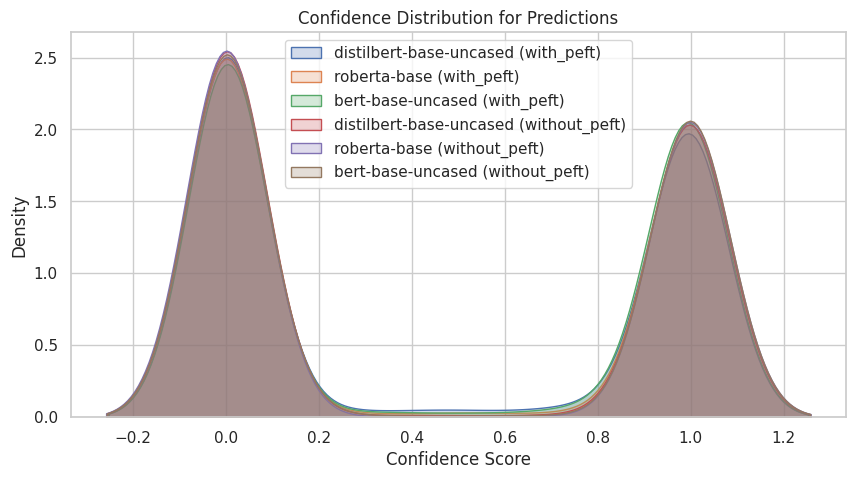

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve

def load_model_results(base_path):
    data = {}
    for peft_type in ["with_peft", "without_peft"]:
        peft_path = os.path.join(base_path, peft_type)
        if not os.path.exists(peft_path):
            continue
        
        for model_name in os.listdir(peft_path):
            model_path = os.path.join(peft_path, model_name)
            if not os.path.isdir(model_path):
                continue
            
            model_key = f"{model_name} ({peft_type})"
            data[model_key] = {}
            
            for file in glob.glob(os.path.join(model_path, "*.parquet")):
                file_key = os.path.basename(file).replace(".parquet", "")
                data[model_key][file_key] = pd.read_parquet(file)
    
    return data

def visualize_results(data):
    sns.set(style="whitegrid")
    
    # Training and Evaluation Loss Over Steps
    plt.figure(figsize=(10, 5))
    for model, files in data.items():
        if "training_logs" in files:
            df = files["training_logs"]
            plt.plot(df["step"], df["loss"], label=f"{model} (Train Loss)")
        if "eval_logs" in files:
            df = files["eval_logs"]
            plt.plot(df["step"], df["loss"], linestyle="dashed", label=f"{model} (Eval Loss)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Over Steps")
    plt.legend()
    plt.show()
    
    # Learning Rate vs. Loss
    plt.figure(figsize=(10, 5))
    for model, files in data.items():
        if "training_logs" in files:
            df = files["training_logs"]
            plt.plot(df["learning_rate"], df["loss"], label=f"{model}")
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.title("Learning Rate vs. Loss")
    plt.legend()
    plt.show()
    
    # Precision-Recall Curve
    plt.figure(figsize=(6, 6))
    for model, files in data.items():
        if "sklearn_predictions" in files:
            df = files["sklearn_predictions"]
            precision, recall, _ = precision_recall_curve(df["true_label"], df["confidence_positive"])
            plt.plot(recall, precision, label=f"{model}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
    
    # Calibration Plot
    plt.figure(figsize=(6, 6))
    for model, files in data.items():
        if "sklearn_predictions" in files:
            df = files["sklearn_predictions"]
            prob_true, prob_pred = calibration_curve(df["true_label"], df["confidence_positive"], n_bins=10)
            plt.plot(prob_pred, prob_true, marker="o", label=f"{model}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Plot")
    plt.legend()
    plt.show()
    
    # Evaluation Metrics Over Epochs
    plt.figure(figsize=(10, 5))
    for model, files in data.items():
        if "eval_logs" in files:
            df = files["eval_logs"]
            plt.plot(df["epoch"], df["accuracy"], label=f"{model} (Accuracy)")
            plt.plot(df["epoch"], df["f1"], linestyle="dashed", label=f"{model} (F1)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.title("Evaluation Metrics Over Epochs")
    plt.legend()
    plt.show()
    
    # Training Time Per Model
    plt.figure(figsize=(10, 5))
    times = {model: files["eval_logs"]["runtime"].sum() for model, files in data.items() if "eval_logs" in files}
    sns.barplot(x=list(times.keys()), y=list(times.values()))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Model")
    plt.ylabel("Total Training Time (s)")
    plt.title("Total Training Time Per Model")
    plt.show()
    
    # Bar Plots for F1, Accuracy, Precision
    metrics = ["accuracy", "f1", "precision"]
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        values = {model: files["sklearn_metrics"][metric].iloc[0] for model, files in data.items() if "sklearn_metrics" in files}
        sns.barplot(x=list(values.keys()), y=list(values.values()))
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Model")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} Scores Per Model")
        plt.show()
    
    # Confusion Matrix Heatmap
    for model, files in data.items():
        if "sklearn_confusion" in files:
            df = files["sklearn_confusion"]
            cm = df.iloc[:, 1:].values.reshape(2, 2)  # Extracting values
            plt.figure(figsize=(5, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["Actual Neg", "Actual Pos"])
            plt.title(f"Confusion Matrix - {model}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()
    
    # ROC Curve
    plt.figure(figsize=(6, 6))
    for model, files in data.items():
        if "sklearn_roc" in files:
            df = files["sklearn_roc"]
            plt.plot(df["false_positive_rate"], df["true_positive_rate"], label=f"{model} (AUC: {df['auc'].iloc[0]:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()
    
    # Predictions Confidence Distribution
    plt.figure(figsize=(10, 5))
    for model, files in data.items():
        if "sklearn_predictions" in files:
            df = files["sklearn_predictions"]
            sns.kdeplot(df["confidence_positive"], label=model, fill=True)
    plt.xlabel("Confidence Score")
    plt.ylabel("Density")
    plt.title("Confidence Distribution for Predictions")
    plt.legend()
    plt.show()



data = load_model_results("/home/nikl/programming/fhdw/knowledge_engineering_ausarbeitung/fakenews_detection/data/model_evaluation")
visualize_results(data)


In [27]:
print(data["distilbert-base-uncased (with_peft)"].keys())
display(data["distilbert-base-uncased (with_peft)"]["summary_logs"])
display(data["distilbert-base-uncased (with_peft)"]["eval_logs"])
display(data["distilbert-base-uncased (with_peft)"]["training_logs"])

dict_keys(['summary_logs', 'sklearn_roc', 'sklearn_confusion', 'training_logs', 'sklearn_metrics', 'sklearn_predictions', 'eval_logs'])


,epoch,step,total_flos,train_loss,train_runtime,train_samples_per_second,train_steps_per_second
0,8.0,11040,4.791320e+16,0.132675,2998.6617,117.794,3.682


,epoch,step,loss,accuracy,f1,precision,recall,runtime,samples_per_second,steps_per_second,loss_change,best_loss_so_far,best_accuracy_so_far
0,0.144928,200,0.663172,0.556833,0.023747,0.971429,0.012021,23.9037,527.784,16.525,NaN,0.663172,0.556833
1,0.289855,400,0.448216,0.800808,0.771898,0.793284,0.751635,22.4528,561.889,17.592,-0.214956,0.448216,0.800808
2,0.434783,600,0.327469,0.860178,0.840246,0.861467,0.820046,23.6241,534.031,16.720,-0.120747,0.327469,0.860178
3,0.579710,800,0.259374,0.892438,0.879858,0.881341,0.878381,23.9316,527.170,16.505,-0.068095,0.259374,0.892438
4,0.724638,1000,0.254351,0.893548,0.873885,0.932091,0.822521,22.3840,563.617,17.647,-0.005022,0.254351,0.893548
5,0.869565,1200,0.214240,0.909718,0.897174,0.916790,0.878381,23.6419,533.629,16.708,-0.040112,0.214240,0.909718
6,1.014493,1400,0.196426,0.917327,0.907198,0.913293,0.901184,23.4972,536.915,16.811,-0.017814,0.196426,0.917327
7,1.159420,1600,0.180595,0.925016,0.916090,0.919352,0.912851,23.6906,532.533,16.673,-0.015830,0.180595,0.925016
8,1.304348,1800,0.171325,0.929930,0.920173,0.940558,0.900654,23.6255,534.000,16.719,-0.009270,0.171325,0.929930
9,1.449275,2000,0.146618,0.937302,0.929369,0.939011,0.919922,22.6124,557.925,17.468,-0.024707,0.146618,0.937302


,loss,grad_norm,learning_rate,epoch,step,loss_change,loss_change_rate
0,0.6857,0.731370,2.000000e-06,0.036232,50,NaN,NaN
1,0.6846,1.990840,4.000000e-06,0.072464,100,-0.0011,-0.001604
2,0.6723,1.362695,6.000000e-06,0.108696,150,-0.0123,-0.017967
3,0.6706,0.671238,8.000000e-06,0.144928,200,-0.0017,-0.002529
4,0.6596,0.721342,1.000000e-05,0.181159,250,-0.0110,-0.016403
...,...,...,...,...,...,...,...
215,0.0786,5.170223,4.648956e-07,7.826087,10800,0.0155,0.245642
216,0.0681,6.447653,3.700190e-07,7.862319,10850,-0.0105,-0.133588
217,0.0632,0.065355,2.751423e-07,7.898551,10900,-0.0049,-0.071953
218,0.0751,0.416310,1.802657e-07,7.934783,10950,0.0119,0.188291
